# Pytorch Geometric

## Introduction

In [1]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
#  Data(edge_index=[2, 4], x=[3, 1])

In [2]:
data

Data(x=[3, 1], edge_index=[2, 4])

In [4]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
data
# Data(edge_index=[2, 4], x=[3, 1])


Data(x=[3, 1], edge_index=[2, 4])

In [5]:
print(data.keys)

['edge_index', 'x']


In [6]:
print(data['x'])

tensor([[-1.],
        [ 0.],
        [ 1.]])


In [7]:
for key, item in data:
    print(f'{key} found in data')

x found in data
edge_index found in data


In [8]:
'edge_attr' in data

False

In [9]:
data.num_nodes

3

In [10]:
data.num_edges

4

In [11]:
data.num_node_features

1

In [12]:
data.has_isolated_nodes()

False

In [13]:
data.has_self_loops()

False

In [14]:
data.is_directed()

False

In [15]:
from torch_geometric.datasets import TUDataset

In [16]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


In [18]:
print(len(dataset))
print(dataset.num_classes)
print(dataset.num_node_features)

600
6
3


In [22]:
dataset[4]

Data(edge_index=[2, 90], x=[23, 3], y=[1])

In [24]:
dataset = dataset.shuffle()

train_dataset = dataset[:540]
test_dataset = dataset[540:]

In [25]:
from torch_scatter import scatter_mean
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

i = 0
for data in loader:
    print(i)
    print(data)
    print(data.num_graphs)
    x = scatter_mean(data.x, data.batch, dim=0)
    print(x.size())
    i += 1

0
DataBatch(edge_index=[2, 4472], x=[1144, 21], y=[32], batch=[1144], ptr=[33])
32
torch.Size([32, 21])
1
DataBatch(edge_index=[2, 3466], x=[887, 21], y=[32], batch=[887], ptr=[33])
32
torch.Size([32, 21])
2
DataBatch(edge_index=[2, 3698], x=[932, 21], y=[32], batch=[932], ptr=[33])
32
torch.Size([32, 21])
3
DataBatch(edge_index=[2, 4346], x=[1132, 21], y=[32], batch=[1132], ptr=[33])
32
torch.Size([32, 21])
4
DataBatch(edge_index=[2, 3930], x=[1009, 21], y=[32], batch=[1009], ptr=[33])
32
torch.Size([32, 21])
5
DataBatch(edge_index=[2, 3562], x=[906, 21], y=[32], batch=[906], ptr=[33])
32
torch.Size([32, 21])
6
DataBatch(edge_index=[2, 3722], x=[992, 21], y=[32], batch=[992], ptr=[33])
32
torch.Size([32, 21])
7
DataBatch(edge_index=[2, 4128], x=[1041, 21], y=[32], batch=[1041], ptr=[33])
32
torch.Size([32, 21])
8
DataBatch(edge_index=[2, 3896], x=[1011, 21], y=[32], batch=[1011], ptr=[33])
32
torch.Size([32, 21])
9
DataBatch(edge_index=[2, 4188], x=[1040, 21], y=[32], batch=[1040], pt

In [26]:
torch.cuda.is_available()

False

## Learning Methods on Graphs

In [29]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [32]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8110


## Creating your own data

In [2]:
import pandas as pd

### Correlation Based Adjacency Matrix

In [16]:
data = pd.read_parquet("data/wind/enriched.parquet")[["forecast_dt", "rt_plant_id", "production"]]
data = pd.pivot_table(data, index="forecast_dt", columns="rt_plant_id", values="production")

In [17]:
data

rt_plant_id,672,749,757,968,969,1194,1459,1460,1470,1472,...,2225,2235,2288,2291,2323,2326,2374,2397,2420,2538
forecast_dt,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+03:00,1.00,1.0,0.0,7.0,22.0,0.79,11.00,20.70,3.0,27.0,...,0.27,7.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00+03:00,4.00,1.0,0.0,19.0,27.0,2.86,19.00,22.20,21.0,29.0,...,4.18,10.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 06:00:00+03:00,4.00,0.0,0.0,3.0,14.0,4.27,18.00,19.60,9.0,28.0,...,3.80,10.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 09:00:00+03:00,17.00,0.0,0.3,0.0,0.0,5.11,16.00,26.20,14.0,28.0,...,4.96,11.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 12:00:00+03:00,15.00,0.0,1.6,0.0,0.0,1.62,8.00,28.63,10.0,22.0,...,2.50,7.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27 19:00:00+03:00,0.00,0.0,0.0,25.0,20.0,0.00,23.20,40.00,9.0,28.0,...,0.00,11.13,11.56,0.04,2.74,3.0,20.0,0.0,0.86,20.0
2022-01-27 20:00:00+03:00,0.13,0.0,0.0,11.0,8.0,0.00,23.23,37.00,7.0,26.0,...,0.00,9.97,11.45,0.03,4.33,1.0,18.5,0.0,0.00,18.0
2022-01-27 21:00:00+03:00,0.00,0.0,0.0,20.0,6.0,0.02,22.50,38.00,1.0,23.0,...,0.00,9.14,12.00,0.00,1.98,0.0,18.1,0.0,0.45,20.0


In [20]:
THRESHOLD = 0.5
corr_ = data.corr()
corr_ = corr_[abs(corr_) > THRESHOLD].fillna(0)
corr_

rt_plant_id,672,749,757,968,969,1194,1459,1460,1470,1472,...,2225,2235,2288,2291,2323,2326,2374,2397,2420,2538
rt_plant_id,,,,,,,,,,,,,,,,,,,,,
672,1.000000,0.000000,0.815435,0.543633,0.696294,0.718731,0.000000,0.0,0.0,0.000000,...,0.749478,0.0,0.0,0.819866,0.548398,0.519232,0.000000,0.751620,0.547100,0.000000
749,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.537381,0.000000
757,0.815435,0.000000,1.000000,0.620831,0.732498,0.660537,0.000000,0.0,0.0,0.000000,...,0.778414,0.0,0.0,0.779544,0.611758,0.608373,0.000000,0.711460,0.626734,0.000000
968,0.543633,0.000000,0.620831,1.000000,0.755638,0.000000,0.000000,0.0,0.0,0.000000,...,0.512873,0.0,0.0,0.531044,0.797090,0.661151,0.552956,0.564793,0.672175,0.000000
969,0.696294,0.000000,0.732498,0.755638,1.000000,0.533873,0.000000,0.0,0.0,0.000000,...,0.625770,0.0,0.0,0.683516,0.724977,0.696660,0.000000,0.618326,0.747259,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,0.519232,0.000000,0.608373,0.661151,0.696660,0.000000,0.000000,0.0,0.0,0.000000,...,0.591382,0.0,0.0,0.527088,0.785868,1.000000,0.000000,0.572393,0.564756,0.000000
2374,0.000000,0.000000,0.000000,0.552956,0.000000,0.000000,0.659581,0.0,0.0,0.716362,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.511918,0.503562
2397,0.751620,0.000000,0.711460,0.564793,0.618326,0.740576,0.000000,0.0,0.0,0.000000,...,0.721020,0.0,0.0,0.731340,0.580431,0.572393,0.000000,1.000000,0.000000,0.000000


In [40]:
corr_.replace(1, 0, inplace=True)

In [53]:
edges[0]

[[672, 757],
 [672, 968],
 [672, 969],
 [672, 1194],
 [672, 1484],
 [672, 1485],
 [672, 1487],
 [672, 1488],
 [672, 1489],
 [672, 1490],
 [672, 1491],
 [672, 1492],
 [672, 1493],
 [672, 1494],
 [672, 1498],
 [672, 1499],
 [672, 1501],
 [672, 1503],
 [672, 1504],
 [672, 1505],
 [672, 1506],
 [672, 1507],
 [672, 1508],
 [672, 1509],
 [672, 1511],
 [672, 1512],
 [672, 1513],
 [672, 1514],
 [672, 1516],
 [672, 1517],
 [672, 1518],
 [672, 1519],
 [672, 1523],
 [672, 1525],
 [672, 1527],
 [672, 1528],
 [672, 1537],
 [672, 1578],
 [672, 1655],
 [672, 1709],
 [672, 1737],
 [672, 1741],
 [672, 1759],
 [672, 1761],
 [672, 1781],
 [672, 1843],
 [672, 1878],
 [672, 1883],
 [672, 1928],
 [672, 1943],
 [672, 1945],
 [672, 2040],
 [672, 2050],
 [672, 2058],
 [672, 2062],
 [672, 2063],
 [672, 2070],
 [672, 2073],
 [672, 2083],
 [672, 2098],
 [672, 2112],
 [672, 2114],
 [672, 2116],
 [672, 2123],
 [672, 2125],
 [672, 2140],
 [672, 2166],
 [672, 2180],
 [672, 2225],
 [672, 2291],
 [672, 2323],
 [672, 23

In [65]:
import itertools

edges = []
for id, row in corr_.iterrows():
    edges.append([[id, _] for _ in row[row > 0].index.tolist()])

edges = list(itertools.chain(*edges))

In [69]:
len(edges[0])

2

In [64]:
edges = np.asarray(edges, dtype=float)
# b.reshape(2, len(b)) 

In [30]:
for id, i in corr_.iteritems():
    print(i)

rt_plant_id
672     1.000000
749     0.000000
757     0.815435
968     0.543633
969     0.696294
          ...   
2326    0.519232
2374    0.000000
2397    0.751620
2420    0.547100
2538    0.000000
Name: 672, Length: 101, dtype: float64
rt_plant_id
672     0.000000
749     1.000000
757     0.000000
968     0.000000
969     0.000000
          ...   
2326    0.000000
2374    0.000000
2397    0.000000
2420    0.537381
2538    0.000000
Name: 749, Length: 101, dtype: float64
rt_plant_id
672     0.815435
749     0.000000
757     1.000000
968     0.620831
969     0.732498
          ...   
2326    0.608373
2374    0.000000
2397    0.711460
2420    0.626734
2538    0.000000
Name: 757, Length: 101, dtype: float64
rt_plant_id
672     0.543633
749     0.000000
757     0.620831
968     1.000000
969     0.755638
          ...   
2326    0.661151
2374    0.552956
2397    0.564793
2420    0.672175
2538    0.000000
Name: 968, Length: 101, dtype: float64
rt_plant_id
672     0.696294
749     0.000000
75

In [23]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
>>> Data(edge_index=[2, 4], x=[3, 1])

SyntaxError: invalid syntax (2116957171.py, line 9)

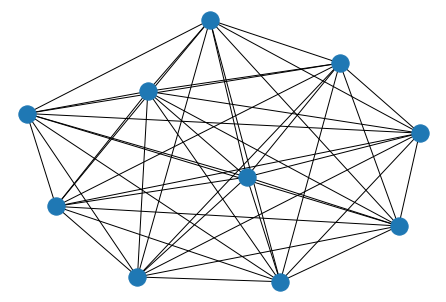

In [22]:
import networkx as nx
G = nx.complete_graph(10)

nx.draw(G)

In [33]:
locations = pd.read_csv("data/wind/ege_farms.csv")
locations[locations["rt_plant_id"].isin(corr_.sort_values(2538).tail(10).index.tolist())]

,FacilityId,eic,province,subProvince,lon,lat,name,rt_plant_id
27,6158,40W000000004373L,Aydin,Çine,28.034082,37.610605,TURGUTTEPE RES,1459
43,6110,40W000000005892T,Aydin,Çine,28.034082,37.610605,MADRANBABA RES,2538
61,6020,40W0000000090819,Aydin,Koçarlı,27.692614,37.691466,BAĞARASI RES,1929
62,6118,40W0000000090827,Izmir,Tire,27.697942,38.064870,ÖDEMİŞ RES,1900
64,6152,40W0000000095217,Aydin,Didim,27.306191,37.438939,SUAY AKBÜK RES,1944
72,6004,40W000000009763K,Mugla,Milas,27.732642,37.284770,AKBÜK2 RES,2031
79,6120,40W000000010403F,Aydin,Köşk,28.106745,37.942656,OVA RES,2089
84,6059,40W000000010584M,Mugla,Merkez,28.437919,37.227949,FATMA RES,2113
90,6157,40W000000011142C,Izmir,Tire,27.697942,38.064870,TİRE RES,2184
92,6088,40W000000011549J,Mugla,Bodrum,27.490532,37.059491,KAROVA RES,2224


In [77]:
locations[locations["rt_plant_id"].isin([1712, , 2288])]

,FacilityId,eic,province,subProvince,lon,lat,name,rt_plant_id
35,6038,40W000000005088F,Aydin,Merkez,27.948734,37.860760,ÇATALBÜK RES,1470
69,6148,40W000000009583M,Aydin,Söke,27.384445,37.647136,SÖKE RES,1977
95,6046,40W000000011905N,Mugla,Datça,27.679906,36.741677,DATÇA AKSA RES,2288


In [84]:
# corr_.count(axis=0).mean()
# corr_.count(axis=0).sort_values()

59.56435643564357

In [71]:
import numpy as np
# np.fill_diagonal(corr_.values, 0)

# corr_.max().sort_values()
# corr_.max().sort_values().tail(20)

In [76]:
# bütün lokasyonlar ilçelere göre sadece
locations.groupby(["lat", "lon", "province", "subProvince"]).count().reset_index().sort_values("province", ascending=False).head()

,lat,lon,province,subProvince,FacilityId,eic,name,rt_plant_id
44,40.277127,27.224720,Çanakkale,Biga,1,1,1,1
42,40.269261,26.786767,Çanakkale,Lapseki,1,1,1,1
38,40.051362,26.490631,Çanakkale,Merkez,4,4,4,4
35,39.798211,26.291050,Çanakkale,Ezine,3,3,3,3
31,39.586788,26.371420,Çanakkale,Ayvacık,1,1,1,1


In [86]:
corr_

rt_plant_id,672,749,757,968,969,1194,1459,1460,1470,1472,...,2225,2235,2288,2291,2323,2326,2374,2397,2420,2538
rt_plant_id,,,,,,,,,,,,,,,,,,,,,
672,0.000000,0.000000,0.815435,0.543633,0.696294,0.718731,0.000000,0.0,0.0,0.000000,...,0.749478,0.0,0.0,0.819866,0.548398,0.519232,0.000000,0.751620,0.547100,0.000000
749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.537381,0.000000
757,0.815435,0.000000,0.000000,0.620831,0.732498,0.660537,0.000000,0.0,0.0,0.000000,...,0.778414,0.0,0.0,0.779544,0.611758,0.608373,0.000000,0.711460,0.626734,0.000000
968,0.543633,0.000000,0.620831,0.000000,0.755638,0.000000,0.000000,0.0,0.0,0.000000,...,0.512873,0.0,0.0,0.531044,0.797090,0.661151,0.552956,0.564793,0.672175,0.000000
969,0.696294,0.000000,0.732498,0.755638,0.000000,0.533873,0.000000,0.0,0.0,0.000000,...,0.625770,0.0,0.0,0.683516,0.724977,0.696660,0.000000,0.618326,0.747259,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,0.519232,0.000000,0.608373,0.661151,0.696660,0.000000,0.000000,0.0,0.0,0.000000,...,0.591382,0.0,0.0,0.527088,0.785868,0.000000,0.000000,0.572393,0.564756,0.000000
2374,0.000000,0.000000,0.000000,0.552956,0.000000,0.000000,0.659581,0.0,0.0,0.716362,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.511918,0.503562
2397,0.751620,0.000000,0.711460,0.564793,0.618326,0.740576,0.000000,0.0,0.0,0.000000,...,0.721020,0.0,0.0,0.731340,0.580431,0.572393,0.000000,0.000000,0.000000,0.000000


### Location Based Adjacency Matrix

In [3]:
locations = pd.read_csv("data/wind/ege_farms.csv")
data = pd.read_parquet("data/wind/enriched.parquet")
locations = locations[["lat", "lon", "rt_plant_id"]]
locations = locations[locations["rt_plant_id"].isin(data["rt_plant_id"].unique())]

In [4]:
from scipy.spatial.distance import squareform, pdist
distance_matrix = pd.DataFrame(squareform(pdist(locations.iloc[:, :-1])), columns=locations.rt_plant_id.unique(), index=locations.rt_plant_id.unique()) * 111

<AxesSubplot:>

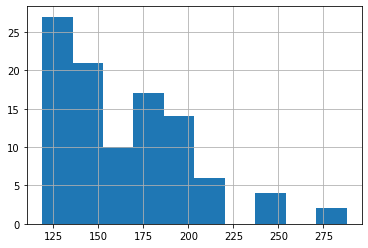

In [5]:
distance_matrix.mean().hist()

<AxesSubplot:>

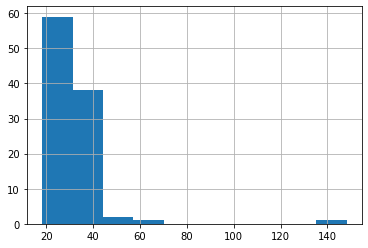

In [6]:
import numpy as np
distance_matrix.replace(0, np.nan).min().hist()

In [7]:
distance_matrix.replace(0, np.nan).min().sort_values()

2116     18.203728
1759     18.203728
2062     18.203728
2050     18.283240
1504     18.283240
           ...    
2114     41.709286
1787     47.116738
1945     48.620624
2113     61.753357
1712    148.195702
Length: 101, dtype: float64

In [15]:
from sklearn.preprocessing import minmax_scale

DISTANCE_THRESHOLD = 100

df = distance_matrix[distance_matrix > DISTANCE_THRESHOLD].fillna(0)
df = pd.DataFrame(minmax_scale(df), columns=distance_matrix.columns, index=distance_matrix.index)
df

,1503,1485,1499,1490,1524,1194,1516,1506,1507,1460,...,2073,2288,749,2326,2397,672,1781,2291,2323,2374
1503,0.000000,0.505662,0.505662,0.000000,0.795084,0.000000,0.427394,0.506608,0.495701,0.885047,...,0.531862,0.885047,0.505662,0.000000,0.000000,0.427394,0.506608,0.343874,0.438338,0.778213
1485,0.504559,0.000000,0.000000,0.504559,0.742012,0.504559,0.722818,0.000000,0.694565,0.507004,...,0.000000,0.507004,0.000000,0.481030,0.504559,0.722818,0.000000,0.661665,0.470818,0.355946
1499,0.504559,0.000000,0.000000,0.504559,0.742012,0.504559,0.722818,0.000000,0.694565,0.507004,...,0.000000,0.507004,0.000000,0.481030,0.504559,0.722818,0.000000,0.661665,0.470818,0.355946
1490,0.000000,0.505662,0.505662,0.000000,0.795084,0.000000,0.427394,0.506608,0.495701,0.885047,...,0.531862,0.885047,0.505662,0.000000,0.000000,0.427394,0.506608,0.343874,0.438338,0.778213
1524,0.503766,0.471166,0.471166,0.503766,0.000000,0.503766,0.371872,0.000000,0.000000,0.560766,...,0.430811,0.560766,0.471166,0.355855,0.503766,0.371872,0.000000,0.350004,0.000000,0.463032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,0.431101,0.730681,0.730681,0.431101,0.592010,0.431101,0.000000,0.652888,0.000000,0.892723,...,0.726606,0.892723,0.730681,0.451939,0.431101,0.000000,0.652888,0.000000,0.531670,0.829694
1781,0.385743,0.000000,0.000000,0.385743,0.000000,0.385743,0.492850,0.000000,0.404776,0.544992,...,0.000000,0.544992,0.000000,0.000000,0.385743,0.492850,0.000000,0.427915,0.000000,0.397220
2291,0.330175,0.636694,0.636694,0.330175,0.530397,0.330175,0.000000,0.539603,0.000000,0.849788,...,0.631717,0.849788,0.636694,0.324685,0.330175,0.000000,0.539603,0.000000,0.410286,0.768135
2323,0.319272,0.343678,0.343678,0.319272,0.000000,0.319272,0.383922,0.000000,0.000000,0.624181,...,0.315101,0.624181,0.343678,0.000000,0.319272,0.383922,0.000000,0.311239,0.000000,0.494232


In [95]:
A = (distance_matrix-distance_matrix.min())/(distance_matrix.max()-distance_matrix.min())
A
# A.to_csv("data/wind/distance_matrix.csv")

,1503,1485,1499,1490,1524,1194,1516,1506,1507,1460,...,2073,2288,749,2326,2397,672,1781,2291,2323,2374
1503,0.000000,0.505662,0.505662,0.000000,0.795084,0.000000,0.427394,0.506608,0.495701,0.885047,...,0.531862,0.885047,0.505662,0.285612,0.000000,0.427394,0.506608,0.343874,0.438338,0.778213
1485,0.504559,0.000000,0.000000,0.504559,0.742012,0.504559,0.722818,0.315272,0.694565,0.507004,...,0.074510,0.507004,0.000000,0.481030,0.504559,0.722818,0.315272,0.661665,0.470818,0.355946
1499,0.504559,0.000000,0.000000,0.504559,0.742012,0.504559,0.722818,0.315272,0.694565,0.507004,...,0.074510,0.507004,0.000000,0.481030,0.504559,0.722818,0.315272,0.661665,0.470818,0.355946
1490,0.000000,0.505662,0.505662,0.000000,0.795084,0.000000,0.427394,0.506608,0.495701,0.885047,...,0.531862,0.885047,0.505662,0.285612,0.000000,0.427394,0.506608,0.343874,0.438338,0.778213
1524,0.503766,0.471166,0.471166,0.503766,0.000000,0.503766,0.371872,0.322154,0.233870,0.560766,...,0.430811,0.560766,0.471166,0.355855,0.503766,0.371872,0.322154,0.350004,0.284220,0.463032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,0.431101,0.730681,0.730681,0.431101,0.592010,0.431101,0.000000,0.652888,0.222970,0.892723,...,0.726606,0.892723,0.730681,0.451939,0.431101,0.000000,0.652888,0.110984,0.531670,0.829694
1781,0.385743,0.240581,0.240581,0.385743,0.387146,0.385743,0.492850,0.000000,0.404776,0.544992,...,0.198736,0.544992,0.240581,0.232410,0.385743,0.492850,0.000000,0.427915,0.153968,0.397220
2291,0.330175,0.636694,0.636694,0.330175,0.530397,0.330175,0.105646,0.539603,0.181522,0.849788,...,0.631717,0.849788,0.636694,0.324685,0.330175,0.105646,0.539603,0.000000,0.410286,0.768135
2323,0.319272,0.343678,0.343678,0.319272,0.326732,0.319272,0.383922,0.147284,0.283775,0.624181,...,0.315101,0.624181,0.343678,0.118014,0.319272,0.383922,0.147284,0.311239,0.000000,0.494232


In [101]:
A.replace(0, np.nan).replace(1, np.nan).max()

1503    0.990137
1485    0.958944
1499    0.958944
1490    0.990137
1524    0.871380
          ...   
672     0.917451
1781    0.995254
2291    0.907071
2323    0.968263
2374    0.903541
Length: 101, dtype: float64

In [97]:
A.replace(0, np.nan).count(axis=0).sort_values()

1899     92
1501     92
749      92
1505     92
2063     92
       ... 
1514    100
1504    100
2050    100
2031    100
1712    100
Length: 101, dtype: int64